In [1]:
%%R
library(reticulate)
use_condaenv('ethique_env')

UsageError: Cell magic `%%R` not found.


# Privacy et Robusness

Dans ce notebook je vais présenter les différentes attaques présentées dans la trousse à outils d'IMB *Adversarial Robusteness 360* :

 - Evasion
 - Poisoning
 - Inference and Inversion
 - Model Extraction
 
Pour illustrer ces différentes attaques nous allons utilisé la base de données : 

 - German Credit (lien)
 
Le modèle que nous allons attaquer est une régression logisitique en utilisant la librairie *scikit learn* 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from itertools import product, combinations
from copy import deepcopy

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
seed = 2021

## Prépration des données et création du modèle cible

In [3]:
credit = pd.read_csv("data/german_credit_prepared.csv", sep=",", engine="python")

y = credit['default']
X = credit.drop(columns="default")

# Définie quelles colones sont categorielles et quelles sont continue
variables_cat = [col for col in X.columns if credit[col].dtype==object]
variables_ord = [col for col in X.columns if credit[col].dtype==int]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), variables_cat),
        ('ord', StandardScaler(), variables_ord)
    ])

model = Pipeline(
        [
            ('preprocession', preprocess),
            ('logreg', LogisticRegression())
        ]
)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=seed)

logreg = model.fit(X_train, y_train)

In [6]:
def mesure_reg(reg, X_test, y_test):
    y_test_pred = reg.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    total=sum(sum(cm))
    sensitivity_recall = cm[0,0]/(cm[0,0]+cm[1,0])
    print('Sensitivity_recall : ',sensitivity_recall )
    Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    print('Specificity: ', Specificity)
    precision = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Precision: ', precision)
    accuracy =(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    print('Accuracy: ', accuracy)
    
    title = 'Matrice de confusion de la régression logistique'
    disp = plot_confusion_matrix(reg,
                                 X_test,
                                 y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.show()

Sensitivity_recall :  0.8013245033112583
Specificity:  0.6122448979591837
Precision:  0.8642857142857143
Accuracy:  0.755


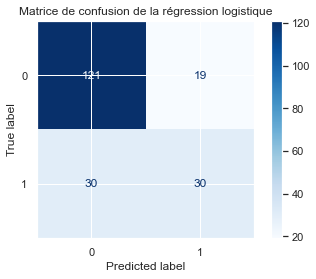

In [7]:
mesure_reg(logreg, X_test, y_test)

# Evasion

On va chercher les variables non vérifiables et les modifiées jusqu'à ce que l'individu refusé soit accepté.

[Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))

On voit qu'il n'y a que très peu de variables que l'on peut modifier et qui ne soit pas vérifiable. C'est une base de données pour crédit ce qui explique cela.
On voit qu'il y a :
 - purpose : correspond à la finalité du prêt
 - personal_status : la condition de vie en couple

On a également des variables difficilements vérifiables :
 - present_emp_since : depuis quand la personne travail à son poste
 - job : le type de travaille de la personne
 - people_under_maintenance : le nombre de personne à charge
 
On choisit ensuite une personne aléatoirement parmis les personnes refusées :

In [8]:
#np.random.seed(seed)
idx_ref = np.where(logreg.predict_proba(X)[:, 1] > 0.5)[0]
idx = np.random.choice(idx_ref)

#idx = 153 # --> juste besoin de changer le but du prêt : 'education', '(vacation - does not exist?)', 'car (new)'
#idx = 232 #--> pas possible de le faire passer
X.iloc[idx]

account_check_status                                          0 <= ... < 200 DM
duration_in_month                                                            30
credit_history                                  delay in paying off in the past
purpose                                                     domestic appliances
credit_amount                                                              1919
savings                                                     100 <= ... < 500 DM
present_emp_since                                                  ... < 1 year
installment_as_income_perc                                                    4
sex                                                                        male
personal _status                                                         single
other_debtors                                                              none
present_res_since                                                             3
property                                

In [9]:
logreg.predict_proba(X.iloc[idx].to_frame().transpose())[:, 1]

array([0.54254801])

In [10]:
var_values = ['purpose', 'personal _status', 'present_emp_since', 'job', 'people_under_maintenance']
fix_values = [x for x in X.columns if x not in var_values]

all_values = [X[col].unique() for col in var_values]
prod = list(product(*all_values))   #produit cartésien

all_X = pd.DataFrame([X.iloc[idx][fix_values].tolist() + list(p) for p in prod],
                      columns=fix_values + var_values)
all_X = all_X[X.columns]
all_X['proba'] = logreg.predict_proba(all_X)[:, 1]

In [11]:
all_X.sort_values('proba', inplace=True)
valid_X = all_X[all_X.proba < 0.5]

# On calcule le nombre de variable qu'on a du modifier
valid_X = valid_X.assign(diff = [(valid_X.iloc[i][var_values] == X.iloc[idx][var_values]).value_counts()[False] 
                                       for i in range(len(valid_X))])

valid_X.sort_values(by=['diff', 'proba'], inplace=True)
valid_X.head(5)

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,diff
516,0 <= ... < 200 DM,30,delay in paying off in the past,car (used),1919,100 <= ... < 500 DM,... < 1 year,4,male,single,...,30,stores,own,2,management/ self-employed/ highly qualified em...,1,none,yes,0.331766,1
20,0 <= ... < 200 DM,30,delay in paying off in the past,domestic appliances,1919,100 <= ... < 500 DM,4 <= ... < 7 years,4,male,single,...,30,stores,own,2,management/ self-employed/ highly qualified em...,1,none,yes,0.398326,1
28,0 <= ... < 200 DM,30,delay in paying off in the past,domestic appliances,1919,100 <= ... < 500 DM,unemployed,4,male,single,...,30,stores,own,2,management/ self-employed/ highly qualified em...,1,none,yes,0.461455,1
500,0 <= ... < 200 DM,30,delay in paying off in the past,car (used),1919,100 <= ... < 500 DM,4 <= ... < 7 years,4,male,single,...,30,stores,own,2,management/ self-employed/ highly qualified em...,1,none,yes,0.216996,2
508,0 <= ... < 200 DM,30,delay in paying off in the past,car (used),1919,100 <= ... < 500 DM,unemployed,4,male,single,...,30,stores,own,2,management/ self-employed/ highly qualified em...,1,none,yes,0.263996,2


In [12]:
def print_diff(new_comb, old_comb):
    diff_comb = (new_comb != old_comb)
    diff_pd = pd.DataFrame([old_comb[diff_comb], new_comb[diff_comb]], index=['old', 'new']).transpose()

    max_ind = max([len(x) for x in diff_pd.index])
    max_old = max([len(x) for x in diff_pd.old])
    max_new = max([len(x) for x in diff_pd.new])

    for i in new_comb[diff_comb].index :
        print(f'{i:<{max_ind}} : {diff_pd.old[i]:<{max_old}} --> {diff_pd.new[i]:<{max_new}}')

In [13]:
print_diff(valid_X.iloc[0][var_values], X.iloc[idx][var_values])

purpose : domestic appliances --> car (used)


In [14]:
X_ref = X.loc[idx_ref]

In [15]:
new = False

if new:
    all_X = pd.DataFrame([X.iloc[idx][fix_values].tolist() + list(p)  + [idx] for idx in tqdm(idx_ref) for p in prod],
                         columns=fix_values + var_values + ['index_old'])
    all_X = all_X[list(X.columns) + ['index_old']]
    all_X['proba'] = logreg.predict_proba(all_X.drop('index_old', axis=1))[:, 1]
    np.savez_compressed('data/privacy/all_X.npz', data=np.array(all_X), columns=all_X.columns)
else:
    file = np.load('data/privacy/all_X.npz', allow_pickle=True)
    all_X = pd.DataFrame(file['data'], columns=file['columns'])

X_false = X.loc[idx_ref]
X_false = X_false.assign(proba = logreg.predict_proba(X_false)[:, 1])

X_false = X_false.assign(proba_min = all_X.groupby('index_old').apply(lambda x: x.sort_values('proba').head(1)) \
                                                                .set_index('index_old').proba)

In [16]:
len(X_false[X_false.proba_min < 0.5])

212

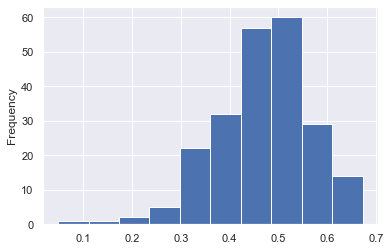

In [17]:
(X_false.proba - X_false.proba_min).plot.hist()
plt.show()

In [18]:
X_false[X_false.proba_min >= 0.5]

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,proba_min
29,< 0 DM,60,delay in paying off in the past,business,6836,... < 100 DM,.. >= 7 years,3,male,single,...,63,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0.864682,0.52768
95,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,business,15945,... < 100 DM,... < 1 year,3,male,single,...,58,none,rent,1,skilled employee / official,1,"yes, registered under the customers name",yes,0.930303,0.664193
334,< 0 DM,24,no credits taken/ all credits paid back duly,radio/television,4110,... < 100 DM,.. >= 7 years,3,male,single,...,23,bank,rent,2,skilled employee / official,2,none,yes,0.866776,0.519487
374,0 <= ... < 200 DM,60,all credits at this bank paid back duly,furniture/equipment,14782,100 <= ... < 500 DM,.. >= 7 years,3,female,divorced,...,60,bank,for free,2,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,0.950675,0.706918
538,< 0 DM,48,existing credits paid back duly till now,car (new),7763,... < 100 DM,.. >= 7 years,4,male,single,...,42,bank,for free,1,management/ self-employed/ highly qualified em...,1,none,yes,0.940321,0.641234
650,< 0 DM,48,existing credits paid back duly till now,(vacation - does not exist?),7476,... < 100 DM,4 <= ... < 7 years,4,male,single,...,50,none,for free,1,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,0.819160,0.506383
714,0 <= ... < 200 DM,60,existing credits paid back duly till now,car (new),14027,... < 100 DM,4 <= ... < 7 years,4,male,single,...,27,none,own,1,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,0.930525,0.6976
728,0 <= ... < 200 DM,48,all credits at this bank paid back duly,business,6416,... < 100 DM,.. >= 7 years,4,female,divorced,...,59,none,rent,1,skilled employee / official,1,none,yes,0.925651,0.524549
832,< 0 DM,45,no credits taken/ all credits paid back duly,business,11816,... < 100 DM,.. >= 7 years,2,male,single,...,29,none,rent,2,skilled employee / official,1,none,yes,0.874828,0.549941
927,< 0 DM,48,existing credits paid back duly till now,car (used),10297,... < 100 DM,4 <= ... < 7 years,4,male,single,...,39,stores,for free,3,skilled employee / official,2,"yes, registered under the customers name",yes,0.772503,0.723198


# Poisoning

On remarque qu'il y a certaine personne pour qui la modification de variables difficilement vérifiables n'est pas suffisant. 
On passe donc à la deuxième attaque *poisoning*. On a vu précédemment que l'individu *232* fait partie des personnes ne pouvant pas utiliser la triche pour pouvoir être accepté.

On va rajouter sa ligne dans la base de donnée d'entrainement et voir si cela a un impact.

In [19]:
y = credit['default']
X = credit.drop(columns="default")

ind = X.iloc[[95]]

In [20]:
ind

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
95,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,business,15945,... < 100 DM,... < 1 year,3,male,single,...,4,unknown / no property,58,none,rent,1,skilled employee / official,1,"yes, registered under the customers name",yes


In [21]:
n = 9
X_train_pois = X_train.append([ind]*n, ignore_index=True)
y_train_pois = pd.Series(list(y_train) + [0]*n)

Sensitivity_recall :  0.8013245033112583
Specificity:  0.6122448979591837
Precision:  0.8642857142857143
Accuracy:  0.755


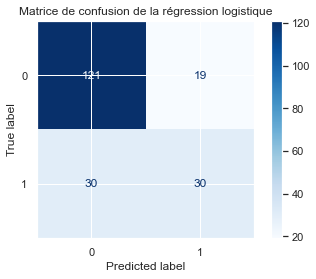

In [22]:
logreg = model.fit(X_train, y_train)

mesure_reg(logreg, X_test, y_test)

In [23]:
logreg.predict_proba(ind)[0,1]

0.9303033802254793

Sensitivity_recall :  0.7806451612903226
Specificity:  0.5777777777777777
Precision:  0.8642857142857143
Accuracy:  0.735


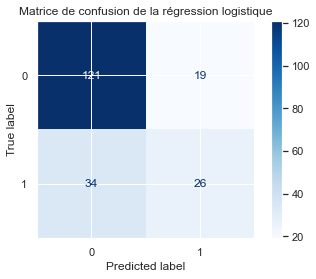

In [24]:
logreg_pois = model.fit(X_train_pois, y_train_pois)

mesure_reg(logreg_pois, X_test, y_test)

In [25]:
logreg_pois.predict_proba(ind)[0,1]

0.47122487407884994

On automatise la recherche du nombre minimum de copie pour passer.

In [26]:
def min_pois(ind):
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [27]:
min_pois(ind)

9

On regarde la distribution pour les personnes qui ont besoin du poisoning

In [28]:
list_min = X_false[X_false.proba_min > 0.5].drop(columns=['proba', 'proba_min']).apply(lambda x: min_pois(x.to_frame().transpose()), axis=1)

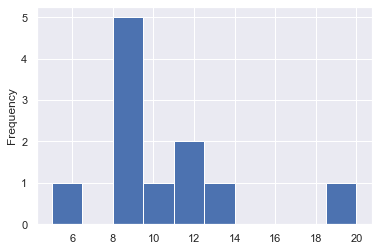

In [29]:
list_min.plot.hist()
plt.show()

On peut coupler les deux premières attaques pour avoir encore moins de copie à rajouter.

In [30]:
ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

In [31]:
print_diff(ind_best_comb.iloc[0], ind.iloc[0])

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


In [32]:
n = 2
X_train_pois_best = X_train.append([ind_best_comb]*n, ignore_index=True)
y_train_pois_best = pd.Series(list(y_train) + [0]*n)

Sensitivity_recall :  0.7894736842105263
Specificity:  0.5833333333333334
Precision:  0.8571428571428571
Accuracy:  0.74


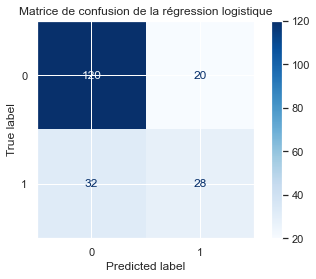

In [33]:
logreg_pois_best = model.fit(X_train_pois_best, y_train_pois_best)

mesure_reg(logreg_pois_best, X_test, y_test)

In [34]:
logreg_pois_best.predict_proba(ind_best_comb)[0,1]

0.49323459330076747

On automatise

In [35]:
def min_pois_best_comb(ind, print_chan=True):
    ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

    print_diff(ind_best_comb.iloc[0], ind.iloc[0]) if print_chan else ...
    
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind_best_comb)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind_best_comb], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [36]:
min_pois_best_comb(ind)

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


2

In [37]:
%%capture
list_min_best_comb = X_false[X_false.proba_min > 0.5].apply(lambda x: 
                                                            min_pois_best_comb(x.to_frame().transpose(), False), axis=1)

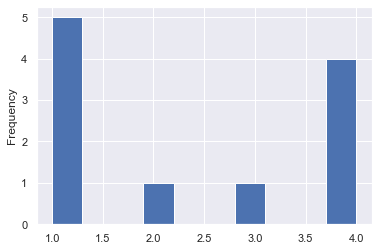

In [38]:
list_min_best_comb.plot.hist()
plt.show()

# Model extraction

Le but de cette attaque est de réccupérer les poids d'un modèle.
On suppose que l'on connait l'architechure : regression logistique.

Ce que l'on va faire c'est créer des nouvelles entrées que l'on va donné à notre modèle blackbox qui va les labélisé puis on va utilser ces labels pour entrainer notre nouveau modèle.

In [39]:
def new_entries(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [40]:
n = len(X_train)
X_new = new_entries(n)
y_new = logreg.predict(X_new)

Sensitivity_recall :  0.8013245033112583
Specificity:  0.6122448979591837
Precision:  0.8642857142857143
Accuracy:  0.755


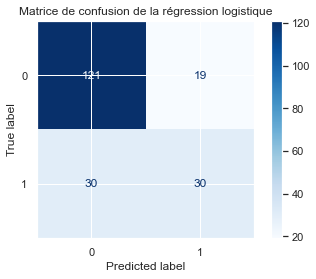

In [41]:
mesure_reg(model.fit(X_train, y_train), X_test, y_test)

Sensitivity_recall :  0.7848101265822784
Specificity:  0.6190476190476191
Precision:  0.8857142857142857
Accuracy:  0.75


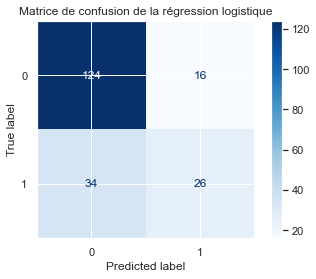

In [42]:
mesure_reg(model.fit(X_new, y_new), X_test, y_test)

In [43]:
def new_entries_unif(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [44]:
n = len(X_train)
X_new_unif = new_entries_unif(n)
logreg = model.fit(X_train, y_train)
y_new_unif = logreg.predict(X_new_unif)

Sensitivity_recall :  0.7926829268292683
Specificity:  0.7222222222222222
Precision:  0.9285714285714286
Accuracy:  0.78


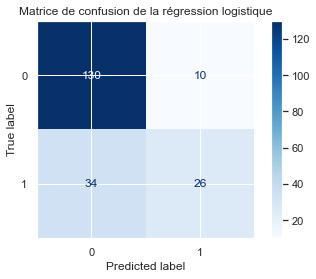

In [45]:
mesure_reg(model.fit(X_new_unif, y_new_unif), X_test, y_test)

Mesure de distance :
 - l'accuracy : mesure de l'efficacité de l'apprentissage
 - la précision : mesure de la distance du modèle original

In [46]:
y_hat = model.fit(X_new, y_new).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.935, Différence d'accuracy : 0.005


In [47]:
y_hat = model.fit(X_new_unif, y_new_unif).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.885, Différence d'accuracy : -0.025


# Trouver un modèle capable de surapprendre

In [48]:
def add_relations(df_orig):
    df = df_orig.copy()
    for i, j in combinations(variables_cat, 2):
        df[i + j] = df[i] + df[j]
    return df

new_variables_cat = variables_cat + [i + j for i, j in combinations(variables_cat, 2)]


# On normalise les colones dans leur noms
all_values = [X[col].unique() for col in variables_cat]
categorie_rel = list(combinations(all_values, 2))

categorie_name = [a + b for a,b in combinations(variables_cat, 2)]
categorie_values = [[a + b for a,b in list(product(*x))] for x in categorie_rel]

preprocessor_comb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=all_values+categorie_values, drop='first', sparse=False), 
         new_variables_cat),
        ('ord', StandardScaler(), variables_ord)
    ])

model_over = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
        ('logreg', LogisticRegression(max_iter=200))
    ]
)

In [49]:
#%timeit model.fit(X_train, y_train)
#print(f"validation : {model.score(X_test, y_test):.3f}, score : {model.score(X_train, y_train):.3f}") 

print("""39.1 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.735, score : 0.787""")

39.1 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.735, score : 0.787


In [50]:
#%timeit model_over.fit(X_train, y_train)
#print(f"validation : {model_over.score(X_test, y_test):.3f}, score : {model_over.score(X_train, y_train):.3f}") 

print("""216 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
validation : 0.725, score : 0.958""")

216 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
validation : 0.725, score : 0.958


On a donc de l'overfit 

# Proprety inference

On va chercher a reccupérer la proportion homme/femme de la base de donnée d'entrainement

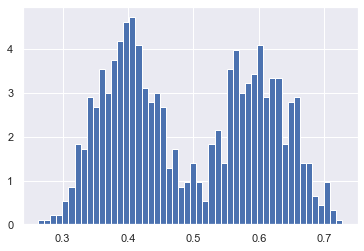

In [51]:
dist = np.random.normal(np.random.choice([0.4, 0.6], size=1000), scale=0.05)
plt.hist(dist, density=True, bins=50)
plt.show()

In [52]:
def new_entries_homme(n, prop=False):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            q = np.clip(np.random.normal(np.random.choice([0.4, 0.6]), scale=0.05), 0, 1)
            list_entries.append(np.random.choice(['male', 'female'], n, p=[q, 1-q]))
        else:
            if prop:
                list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
            else:
                list_entries.append(np.random.choice(X[col].unique(), n))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [53]:
new_entries_homme(1000).sex.value_counts(normalize=True)

male      0.65
female    0.35
Name: sex, dtype: float64

On se place dans le cas suivant :

On a un modèle *model_secret* qui à la structure de *model_chose* et qui est entrainé sur une base de données : *X_train_secret*, et une labélisation : *y_train_secret*.
On cherche à savoir si la base de données secrète avait une majorité d'homme.

Pour se faire on va procéder de la manière suivante :

Comme on n'a pas accès à la base de données *X_train_secret* on va devoir créer une liste de bases : *list_data_X* qui est une liste de base générée avec la fonction : *new_entries_homme* qui génére de nouvelles entrées uniformément pour toutes les variables sauf *sex* où la proportion d'hommes est tirée selon une normale centré en 0,6 ou 0,4 et de écart type 0,05.
On utilise le modèle *model_secret* pour labéliser les nouvelles entrées que l'on garde dans la variable *liste_data_y*. (étape de *model extraction*)

Pour chaque nouvelle base de données on entraine un modèle de la structure *model_choisi* et on récupère les poids de ce modèle.
Tous ces poids forme la base *data_meta_X*. C'est une base de données où chaque entrée $i$ coorespond aux coefficients du modèle entrainé sur *(list_data_X[i], list\_data\_y[i])*.

On crée la labélisation de notre méta-modèle *data_meta_y* en notant $1$ s'il y a plus d'homme que de femme dans le base de données *list_data_X[i]* et 0 sinon.

On va entrainer notre méta-modèle qui est une régression logstique sur *(data_meta_X, data_meta_y)*

On va finalement donner les coefficients de notre modèle secret à notre méta-modèle et il va nous dire si le modèle secret a été entrainé sur une base de données avec une majoritée d'homme (1) ou de femme (0). 

*FAIRE UN SCHÉMA*

In [54]:
n_data = 300
n_entries = len(X_train)

X_train_secret = X_train
y_train_secret = y_train

prop = False
new = False
# Choisir si on veut utiliser le modèle qui surapprend ou pas 
model_choisi = model  #model
name = '_overfit' if model_choisi == model_over else ''
prop_name = '_prop' if prop else '_unif'

model_secret = deepcopy(model_choisi.fit(X_train_secret, y_train_secret))

if new:
    list_data_X = [new_entries_homme(n_entries, prop) for _ in tqdm(range(n_data))]
    dist_homme = np.array([(x.sex.value_counts(normalize=True))['male'] for x in list_data_X])
    
    list_data_y = model_secret.predict(pd.DataFrame(np.array(list_data_X).reshape(-1, 21), 
                                               columns=X.columns)).reshape(n_data, -1)

    data_meta_X = [model_choisi.fit(list_data_X[i], list_data_y[i])['logreg'].coef_[0] 
                       for i in tqdm(range(len(list_data_X)))]
    
    np.savez_compressed(f'data/privacy/data{name}{prop_name}.npz', 
                        data_meta=data_meta_X, 
                        list_homme=dist_homme)
else:
    file = np.load(f'data/privacy/data{name}{prop_name}.npz', allow_pickle=True)
    data_meta_X = file['data_meta']
    dist_homme = file['dist_homme']
    
data_meta_y = (dist_homme > 0.5).astype('int')

### Visualisation de la répartition de la proportion d'hommes dans les bases de données

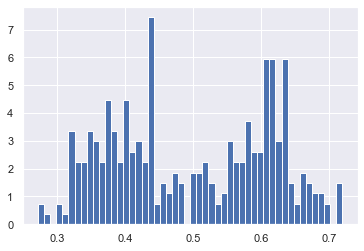

In [55]:
plt.hist(dist_homme, density=True, bins=50)
plt.show()

### Entrainement du méta-modèle

In [56]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y, 
                                                                                        test_size=0.20)
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_train_meta, y_train_meta)

LogisticRegression(max_iter=200)

In [57]:
confusion_matrix(y_test_meta, meta_model.predict(X_test_meta))

array([[14, 18],
       [14, 14]])

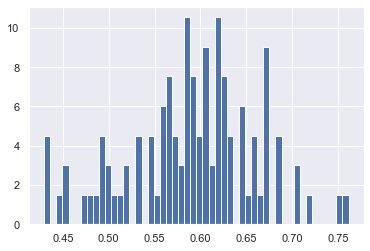

In [58]:
l = []
X_train_meta_all, X_test_meta_all, y_train_meta_all, y_test_meta_all = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y, 
                                                                                        test_size=0.01)
for i in tqdm(range(100)):
    X_train_meta, _, y_train_meta, _ = model_selection.train_test_split(X_train_meta_all, 
                                                                        y_train_meta_all, 
                                                                        test_size=0.20)
    meta_model = LogisticRegression(max_iter=200)
    meta_model.fit(X_train_meta, y_train_meta)
    
    #l += [meta_model.predict_proba(model_secret['logreg'].coef_)[0,1]]
    l += [meta_model.predict_proba([X_test_meta[0]])[0,1]]

plt.hist(l, density=True, bins=50, color='b')
plt.show()

In [59]:
print(y_test_meta[0])

1


### Régression linéaire pour trouver le proportion d'homme

In [60]:
data_meta_y_linear = dist_homme
X_train_meta, X_test_meta, y_train_meta, y_test_meta = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y_linear, 
                                                                                        test_size=0.20, 
                                                                                        random_state=seed)

In [61]:
meta_model_linear = LinearRegression()
meta_model_linear.fit(X_train_meta, y_train_meta)

LinearRegression()

On regarde la différence moyenne en pourcentage entre la prévision du modèle et la réalité

In [62]:
((np.abs(y_test_meta - meta_model_linear.predict(X_test_meta))/y_test_meta) * 100).mean()

24.322101347546095

In [63]:
meta_model_linear.predict(model_secret['logreg'].coef_)

array([-0.00056166])

In [64]:
from sklearn import svm

meta_model_svr = svm.LinearSVR(max_iter=100000)
meta_model_svr.fit(X_train_meta, y_train_meta)

LinearSVR(max_iter=100000)

In [65]:
((np.abs(y_test_meta - meta_model_svr.predict(X_test_meta))/y_test_meta) * 100).mean()

26.67559886789247

In [66]:
meta_model_svr.predict(model_secret['logreg'].coef_)

array([0.15990243])

# Differential Privacy

On utilise la librairie *diffprivlib* qui permet d'implémenter avec des modèles de *sklearn* la *differential privacy*.

In [67]:
import diffprivlib.models as diff

In [68]:
epsilon=1
data_norm=1

model_over_diff = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
        # La seule différence avec model_over
        ('logreg', diff.LogisticRegression(max_iter=200, epsilon=epsilon, data_norm=data_norm))
    ]
)

In [69]:
model_over_diff.fit(X_train, y_train)
print(f"validation : {model_over_diff.score(X_test, y_test):.3f}, score : {model_over_diff.score(X_train, y_train):.3f}") 

validation : 0.485, score : 0.506


C'est là où il y a un problème on ne peut plus vraiment utilisé le modèle secret pour auto-labélisé les nouvelles données car il perd en efficacité donc la labélisation de *y_train_secret* est vraiment différentes de l'auto-labélisation. Il faut donc s'éloigner de la situation initale qui combinait le *proprety inference* et le *model extraction* comme on ne veut que le premier on va suivre le protocole suivant :

 - On va créer un *pool* de données (100000)
 - On utilise le *model_secret* entrainé sur (X_train_secret, y_train_secret) pour auto-labélisé
 - On va tirer une base de données secrete parmis ces données que l'on va renommé *data_secret*
 - La liste de data va être tirée dans la *pool* en tirant le bon nombre d'entrées hommme et femme
 
 - On entraine de la même manière le meta modèle mais cette fois-ci : y_train_secret et le y de list_data_y sont de même forme

#### Creation d'un très grand nombre d'entrées


In [70]:
def new_entries_unif_sex(n):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            list_entries.append(np.random.choice(X[col].unique(), n))
        else:
            list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [71]:
def index_fix_p_homme(p, N):
    nb_homme = round(p * N) 

    male_index = np.random.choice(all_male_index, replace=False, size=nb_homme)
    female_index = np.random.choice(all_female_index, replace=False, size=N-nb_homme)

    return np.concatenate([male_index, female_index])

In [72]:
N = 800
m = 300

new = False

model_predict = model_over.fit(X_train, y_train)

if new:  
    data_pool = new_entries_unif_sex(100000)
    data_pool['defaut'] = model_predict.predict(data_pool)
    
    all_male_index = data_pool[data_pool.sex == 'male'].index
    all_female_index = data_pool[data_pool.sex == 'female'].index
        
    all_p = np.clip(np.random.normal(np.random.choice([0.4, 0.6], size=m), scale=0.05), 0, 1)
    sub_index = [index_fix_p_homme(p, N) for p in tqdm(all_p)]
    np.savez_compressed('data/privacy/diff_data.npz', data_pool=np.array(data_pool), 
                        columns_pool=data_pool.columns, sub_index=np.array(sub_index))
else:
    file = np.load('data/privacy/diff_data.npz', allow_pickle=True)
    
    data_pool = pd.DataFrame(file['data_pool'], columns=file['columns_pool'])
    sub_index = file['sub_index']
    
sub_data = [data_pool.iloc[indexes] for indexes in sub_index]

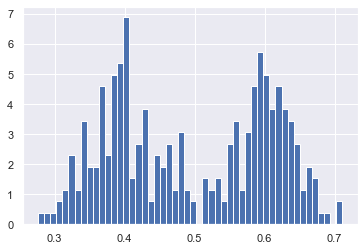

In [73]:
dist_homme = [(x.sex.value_counts(normalize=True))['male'] for x in sub_data]
plt.hist(dist_homme, density=True, bins=50)
plt.show()

In [74]:
new = False

list_data_X = [df.drop('defaut', axis=1) for df in sub_data]

if new:
    list_data_y = [df.defaut for df in sub_data]

    data_meta_X = [model_over.fit(list_data_X[i], list_data_y[i])['logreg'].coef_[0] 
                        for i in tqdm(range(len(list_data_X)))]

    np.savez_compressed('data/privacy/data_meta_over_prop_diff.npz', data_meta=np.array(data_meta_X))
else:
    data_meta_X = np.load('data/privacy/data_meta_over_prop_diff.npz')['data_meta']
    
    
data_meta_y = np.array([df.sex.value_counts().index[0] == 'male' 
                            for df in list_data_X]).astype('int')

In [75]:
X_open, X_secret, y_open, y_secret = model_selection.train_test_split(data_meta_X, 
                                                                        data_meta_y, 
                                                                        test_size=0.20)

meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_open, y_open)
confusion_matrix(y_secret, meta_model.predict(X_secret))

array([[13, 17],
       [13, 17]])

In [81]:
all_male_index = data_pool[data_pool.sex == 'male'].index
all_female_index = data_pool[data_pool.sex == 'female'].index

X_secret = data_pool.iloc[index_fix_p_homme(0.6, 1000)].drop(columns=['defaut'])
y_secret = model_predict.predict(X_secret)
      
X_secret_train, X_secret_test, y_secret_train, y_secret_test = model_selection.train_test_split(X_secret, 
                                                                                                    y_secret, 
                                                                                                    test_size=0.20)

In [83]:
model_over.fit(X_secret_train, y_secret_train)
y_test_pred = model_over.predict(X_secret_test)
cm = confusion_matrix(y_secret_test, y_test_pred)
print(cm)

[[127  13]
 [ 18  42]]


In [84]:
X_secret_train.sex.value_counts(normalize=True)

male      0.60125
female    0.39875
Name: sex, dtype: float64

In [85]:
meta_model.predict_proba(model_over['logreg'].coef_)

array([[0.02598231, 0.97401769]])

On a donc un meta modèle qui ne dépends plus d'un *model extraction* et qui fonctionne bien.
On va maintenant tracer pour différentes valeurs de *epsilon* et de *data_norm* les valeurs de prédiction du méta model et du recal.

In [86]:
def gen_model_diff(epsilon=1, data_norm=1):
    model = Pipeline(
        steps=[
            ('relations', FunctionTransformer(add_relations)), 
            ('preprocession', preprocessor_comb),
            # La seule différence avec model_over
            ('logreg', diff.LogisticRegression(max_iter=200, epsilon=epsilon, data_norm=data_norm))
        ]
    )
    return model

In [87]:
def mesure(model):
    
    y_test_pred = model.predict(X_test_secret)
    cm = confusion_matrix(y_test_secret, y_test_pred)
    
    pred_homme = meta_model.predict_proba(model['logreg'].coef_)[0,1]
    
    recall = cm[0,0]/(cm[0,0]+cm[1,0])
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    precision = cm[0,0]/(cm[0,0]+cm[0,1])
    accuracy =(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
  
    return recall, specificity, precision, accuracy, pred_homme

In [88]:
%%capture --no-display --no-stdout
new = False

columns = ['recall', 'specificity', 'precision', 'accuracy', 'pred_homme', 'eps', 'data_norm']

if new:
    nb_test = 10
    list_eps = np.logspace(-1, 2, 10)
    list_data_norm = np.logspace(-1, 2, 10)
    
    X_secret = data_fix_p_homme(0.6, 1000)
    y_secret = model_predict.predict(X_secret)
    
    X_train_secret, X_test_secret, y_train_secret, y_test_secret = model_selection.train_test_split(X_secret, 
                                                                                                    y_secret, 
                                                                                                    test_size=0.20)
    def mesure(model):
        model.fit(X_train_secret, y_train_secret)
        y_test_pred = model.predict(X_test_secret)
        cm = confusion_matrix(y_test_secret, y_test_pred)

        recall = cm[0,0]/(cm[0,0]+cm[1,0])
        specificity = cm[1,1]/(cm[1,1]+cm[0,1])
        precision = cm[0,0]/(cm[0,0]+cm[0,1])
        accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
        
        pred_homme = meta_model.predict_proba(model['logreg'].coef_)[0,1]

        return recall, specificity, precision, accuracy, pred_homme

    all_mesures = [(*mesure(gen_model_diff(eps, data_norm)), eps, data_norm) for eps in tqdm(list_eps) 
                 for data_norm in list_data_norm 
                     for _ in range(nb_test)]

    df_mesures = pd.DataFrame(all_mesures, columns=columns)
    
    np.save('data/privacy/data_mesures.npy', df_mesures.to_numpy())
else:
    df_mesures = pd.DataFrame(np.load('data/privacy/data_mesures.npy'), columns=columns)